# BASIC STYLE TRANSFER

## Imports
This notebook tries to explain the intrinsics of the most basic implementation of Style Transfer. Please, refer to the `Readme.md` file to see the general description of the project and the basic explanation.

In [1]:
import numpy as np
import os
import sys
from keras import backend as K
from argparse import ArgumentParser
from google.colab import files

!pip install Pillow
from PIL import Image
from IPython.display import Image, display
import matplotlib.pyplot as plt

from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

from scipy.misc import imread, imresize, imsave, fromimage, toimage

from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import warnings

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

Using TensorFlow backend.


## Utils 

### String to boolean converter

In [0]:
#String to boolean converter
def str_to_bool(v):
    return v.lower() in ("true", "yes", "t", "1")

##Variables

In [0]:
img_width = 0
img_height = 0
img_WIDTH = 0
img_HEIGHT = 0
aspect_ratio = 0

THEANO_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
TH_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels_notop.h5'
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


result_prefix = 'res_'

#style_masks_present = args.style_masks is not None
#mask_paths = []

#if style_masks_present:
#    for mask_path in args.style_masks:
#        mask_paths.append(mask_path)

#if style_masks_present:
#    assert len(style_image_paths) == len(mask_paths), "Wrong number of style masks provided.\n" \
#                                                      "Number of style images = %d, \n" \
#                                                      "Number of style mask paths = %d." % \
#                                                      (len(style_image_paths), len(style_masks_present))

#content_mask_present = args.content_mask is not None
#content_mask_path = args.content_mask


#color_mask_present = args.color_mask is not None

# Default value
rescale_image = str_to_bool("False")
#maintain_aspect_ratio = str_to_bool(args.maintain_aspect_ratio)

# Default value
preserve_color = str_to_bool("False")

#these are the weights of the different loss components

#CONTENT WEIGHT
content_weight = 0.025 #default value
total_variation_weight = 8.5e-5 #default value
#total_variation_weight = args.tv_weight


#This array must be just of one position because we are not accepting more than
#one style images. It should be multiplied by the style_scale
style_weights = [1]

## Upload Images
To study how the network works, upload 2 images...

In [4]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

print("Upload the Content Image")
imageContent = upload_files()[0]
print(imageContent)

print("Upload the Style Image")
imageStyle = upload_files()[0]

Upload the Content Image


Saving 1509291534361.43.jpg to 1509291534361.43.jpg
1509291534361.43.jpg
Upload the Style Image


Saving 5027969222d1df2951a62d3d0dae30fa-d8561g8.png to 5027969222d1df2951a62d3d0dae30fa-d8561g8.png


... and display them:

-----------------------------------

Content Image


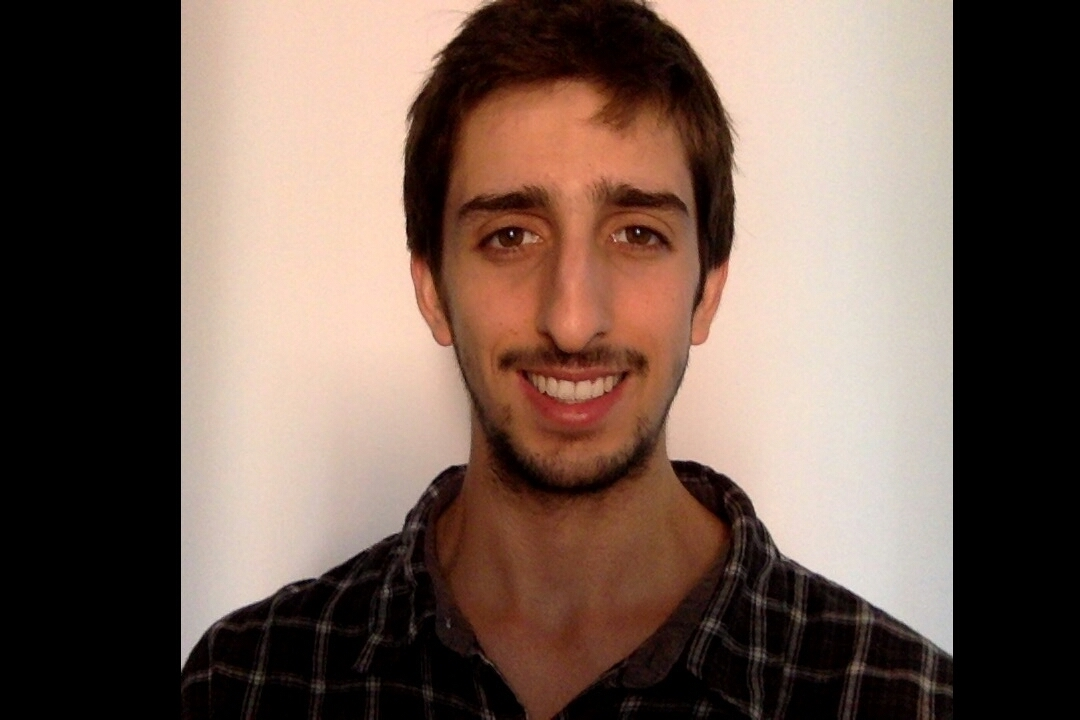


Style Image


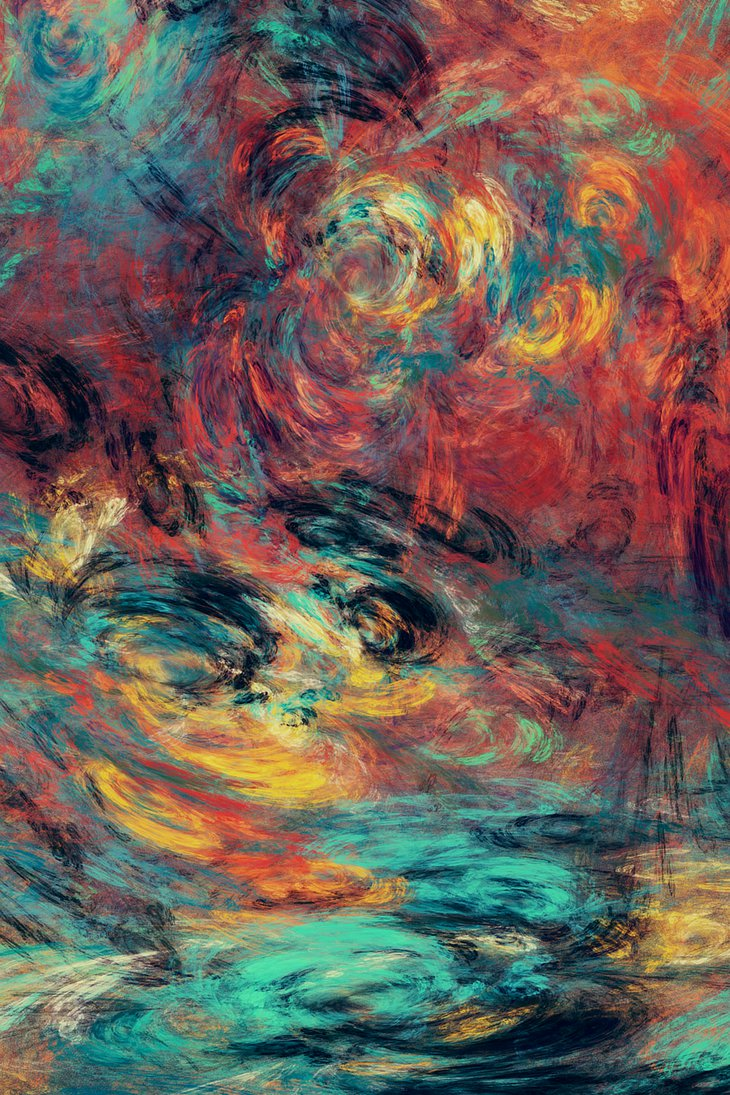

In [5]:
print("-----------------------------------")
print()
print("Content Image")
display(Image(imageContent, width=500))
print()
print("Style Image")
display(Image(imageStyle, width=500))

## Image Preprocessing

Both images are preprocessed and the main parameters of the content image are saved to be used later since the style image will be resized to fit the content image and not otherwise.

In [69]:
global img_width, img_height, img_WIDTH, img_HEIGHT, aspect_ratio

imgContent = imread(imageContent, mode="RGB")  # Prevents crashes due to PNG images (ARGB)
imgStyle = imread(imageStyle, mode="RGB")  # Prevents crashes due to PNG images (ARGB)

#Saving Content image parameters
img_WIDTH = imgContent.shape[0]
img_HEIGHT = imgContent.shape[1]

print('Original sizes')
print(img_WIDTH)
print(img_HEIGHT)

aspect_ratio = float(img_HEIGHT) / img_WIDTH
img_width = 150    # Minimum image size: 400
img_height = int(img_width * aspect_ratio)

print('Modified sizes')
print(img_width)
print(img_height)

#Image resizing (style image resized to content image size)
imgContent = imresize(imgContent, (img_width, img_height)).astype('float32')
imgStyle = imresize(imgStyle, (img_width, img_height)).astype('float32')

# RGB -> BGR for content image
imgContent = imgContent[:, :, ::-1]
imgContent[:, :, 0] -= 103.939
imgContent[:, :, 1] -= 116.779
imgContent[:, :, 2] -= 123.68

# RGB -> BGR for style image
imgStyle = imgStyle[:, :, ::-1]
imgStyle[:, :, 0] -= 103.939
imgStyle[:, :, 1] -= 116.779
imgStyle[:, :, 2] -= 123.68

if K.image_dim_ordering() == "th":
    imgContent = imgContent.transpose((2, 0, 1)).astype('float32')
    imgStyle = imgStyle.transpose((2, 0, 1)).astype('float32')


imgContent = np.expand_dims(imgContent, axis=0)
imgStyle = np.expand_dims(imgStyle, axis=0)

Original sizes
720
1080
Modified sizes
150
225


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


  ## Image to tensor
  
  Both images are converted to tensor to be used in further steps.



In [0]:
content_image = K.variable(imgContent)
style_image = K.variable(imgStyle)

# this will contain our generated image
if K.image_dim_ordering() == 'th':
    combination_image = K.placeholder((1, 3, img_width, img_height))
else:
    combination_image = K.placeholder((1, img_width, img_height, 3))

image_tensors = [content_image]
image_tensors.append(style_image)
image_tensors.append(combination_image)

nb_tensors = len(image_tensors)
nb_style_images = nb_tensors - 2 # Content and Output image not considered

# combine the various images into a single Keras tensor
input_tensor = K.concatenate(image_tensors, axis=0)

if K.image_dim_ordering() == "th":
    shape = (nb_tensors, 3, img_width, img_height)
else:
    shape = (nb_tensors, img_width, img_height, 3)

ip = Input(tensor=input_tensor, batch_shape=shape)


## Network Structure

### VGG16 --> FINALLY WE USE VGG19!

We will be using an already trained Convolutional Network (also known as ConvNet), i.e. VGG16 as shown in the next figure: 

![VGG16](http://jesusutrera.com/articles/img/vgg_model.png) 

As it can be seen... **(explain VGG16)**

Can use AveragePooling2D inplace of MaxPooling2D layers The original paper uses AveragePooling for better results, but this can be changed to use MaxPooling2D layers via the argument --pool_type="max". By default MaxPooling is used, since if offers sharper images, but AveragePooling applies the style better in some cases (especially when style image is the "Starry Night" by Van Gogh).

### The code

In [0]:
# build the VGG16 network with our 3 images as input
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding='same')(ip)
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
# Average Pooling can also be used with: x = AveragePooling2D((2, 2), strides=(2, 2))(x) in all layers
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
# For VGG19 uncomment nextline
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
# For VGG19 uncomment nextline
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)


x = Convolution2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
# For VGG19 uncomment nextline
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_4', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    
model = Model(ip, x)

### Download the pretrained model

Since pretraining a model could take hours, we just download the pretrained model weights in order to speed up the process.

In [72]:
if K.image_dim_ordering() == "th":
  weights = get_file('vgg19_weights_th_dim_ordering_th_kernels_notop.h5', TH_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  #weights = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5', THEANO_WEIGHTS_PATH_NO_TOP, cache_subdir='models')

else:
  weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  #weights = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_WEIGHTS_PATH_NO_TOP, cache_subdir='models')

model.load_weights(weights)

if K.backend() == 'tensorflow' and K.image_dim_ordering() == "th":
    warnings.warn('You are using the TensorFlow backend, yet you '
                  'are using the Theano '
                  'image dimension ordering convention '
                  '(`image_dim_ordering="th"`). '
                  'For best performance, set '
                  '`image_dim_ordering="tf"` in '
                  'your Keras config '
                  'at ~/.keras/keras.json.')
    convert_all_kernels_in_model(model)

print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])
print(shape_dict)

Model loaded.
{'input_5': (3, 150, 225, 3), 'conv1_1': (3, 150, 225, 64), 'conv1_2': (3, 150, 225, 64), 'max_pooling2d_21': (3, 75, 112, 64), 'conv2_1': (3, 75, 112, 128), 'conv2_2': (3, 75, 112, 128), 'max_pooling2d_22': (3, 37, 56, 128), 'conv3_1': (3, 37, 56, 256), 'conv3_2': (3, 37, 56, 256), 'conv3_3': (3, 37, 56, 256), 'conv3_4': (3, 37, 56, 256), 'max_pooling2d_23': (3, 18, 28, 256), 'conv4_1': (3, 18, 28, 512), 'conv4_2': (3, 18, 28, 512), 'conv4_3': (3, 18, 28, 512), 'conv4_4': (3, 18, 28, 512), 'max_pooling2d_24': (3, 9, 14, 512), 'conv5_1': (3, 9, 14, 512), 'conv5_2': (3, 9, 14, 512), 'conv5_3': (3, 9, 14, 512), 'conv5_4': (3, 9, 14, 512), 'max_pooling2d_25': (3, 4, 7, 512)}


## Loss

### Content Loss

It is defined as the mean squared error of difference between feature map representation (values of hidden activations) of the content image (P_l) and feature map representation of the generated image (F_l) at hidden layer (l)

In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    channel_dim = 0 if K.image_dim_ordering() == "th" else -1

    try:
        channels = K.int_shape(base)[channel_dim]
    except TypeError:
        channels = K.shape(base)[channel_dim]
    size = img_width * img_height
    
    #By default the type of content loss is 0: 
    multiplier = 1.
    #... but it can be one of the following:
    # type 2 -> multiplier = 1. / (channels * size)
    # type 1 -> 
    #multiplier = 1. / (2. * (channels ** 0.5) * (size ** 0.5))

    return multiplier * K.sum(K.square(combination - base))

### Style Loss

It is defined as mean squared error between the Gram Matrix representations for the style image (A_l) and the generated image (G_l) respectively in layer (l). Since we have defined our style through the combination of multiple layers, we would sum up the square of the difference for each layer (l). Please note that N and M stands for the size of the height and width of the style image

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination, mask_path=None, nb_channels=None):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return K.sum(K.square(C - S)) / (4. * (channels ** 2) * (size ** 2))


### Gram Matrix

It is only used in style loss computation.

In [0]:
#Gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == "th":
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

### Loss computation



In [76]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict["conv4_2"]  # 'conv5_2' or 'conv4_2'
print(layer_features)
base_image_features = layer_features[0, :, :, :] #Extracts values from the content image (0)
combination_features = layer_features[nb_tensors - 1, :, :, :] #Extracts values from the combination image (nb_tensors-1=2)

print("Computing content loss w/ weight =", content_weight)
loss = loss + content_weight * content_loss(base_image_features,combination_features)
print("-------------------------------------")
print()


channel_index = 1 if K.image_dim_ordering() == "th" else -1

feature_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
for layer_name in feature_layers:
    print("Extracting features from layer", layer_name)
    layer_features = outputs_dict[layer_name]
    shape = shape_dict[layer_name]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
    style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
    sl = []
    
    for j in range(nb_style_images):
        print("  -   Style_reference_features:",style_reference_features[j])
        sl.append(style_loss(style_reference_features[j], combination_features, None, shape))        

    for j in range(nb_style_images):
        print("  -   Computing style loss w/ weight =", style_weights[j])
        loss = loss + (style_weights[j] / len(feature_layers)) * sl[j]
        print("  -   SL(j) - ", sl[j])
        print()

if K.image_dim_ordering() == 'th':
    a = K.square(combination_image[:, :, :img_width - 1, :img_height - 1] - combination_image[:, :, 1:, :img_height - 1])
    b = K.square(combination_image[:, :, :img_width - 1, :img_height - 1] - combination_image[:, :, :img_width - 1, 1:])
else:
    a = K.square(combination_image[:, :img_width - 1, :img_height - 1, :] - combination_image[:, 1:, :img_height - 1, :])
    b = K.square(combination_image[:, :img_width - 1, :img_height - 1, :] - combination_image[:, :img_width - 1, 1:, :])
t_variation = K.sum(K.pow(a + b, 1.25))

loss = loss + total_variation_weight * t_variation

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


Tensor("conv4_2_4/Relu:0", shape=(3, 18, 28, 512), dtype=float32)
Computing content loss w/ weight = 0.025
-------------------------------------

Extracting features from layer conv1_1
  -   Style_reference_features: Tensor("strided_slice_438:0", shape=(150, 225, 64), dtype=float32)
  -   Computing style loss w/ weight = 5
  -   SL(j) -  Tensor("truediv_60:0", shape=(), dtype=float32)

Extracting features from layer conv2_1
  -   Style_reference_features: Tensor("strided_slice_444:0", shape=(75, 112, 128), dtype=float32)
  -   Computing style loss w/ weight = 5
  -   SL(j) -  Tensor("truediv_61:0", shape=(), dtype=float32)

Extracting features from layer conv3_1
  -   Style_reference_features: Tensor("strided_slice_450:0", shape=(37, 56, 256), dtype=float32)
  -   Computing style loss w/ weight = 5
  -   SL(j) -  Tensor("truediv_62:0", shape=(), dtype=float32)

Extracting features from layer conv4_1
  -   Style_reference_features: Tensor("strided_slice_456:0", shape=(18, 28, 512), dtyp

##Evaluation
### Evaluate loss and grad

In [0]:
def eval_loss_and_grads(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_width, img_height))
    else:
        x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

### Evaluation 

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator = Evaluator()

Starting iteration 1 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 20181617000.0  Improvement : 0.000 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_1.png
Iteration 1 completed in 3s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


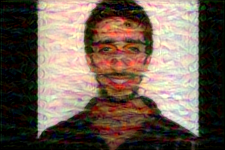

Starting iteration 2 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 11602304000.0  Improvement : 42.511 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_2.png
Iteration 2 completed in 2s


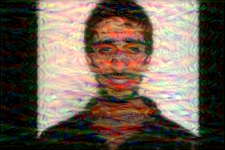

Starting iteration 3 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 9113781000.0  Improvement : 21.449 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_3.png
Iteration 3 completed in 2s


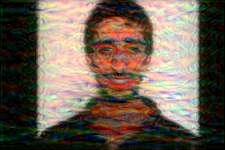

Starting iteration 4 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 7970919000.0  Improvement : 12.540 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_4.png
Iteration 4 completed in 2s


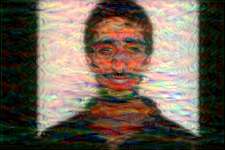

Starting iteration 5 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 7119776300.0  Improvement : 10.678 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_5.png
Iteration 5 completed in 2s


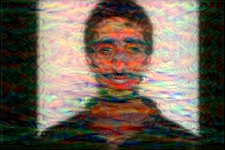

Starting iteration 6 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 6659910000.0  Improvement : 6.459 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_6.png
Iteration 6 completed in 2s


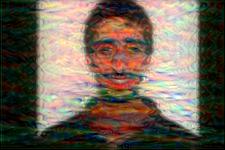

Starting iteration 7 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 6319048000.0  Improvement : 5.118 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_7.png
Iteration 7 completed in 2s


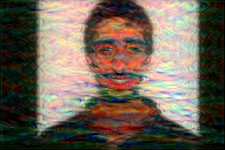

Starting iteration 8 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 6091007500.0  Improvement : 3.609 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_8.png
Iteration 8 completed in 2s


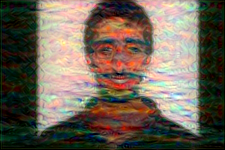

Starting iteration 9 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 5908409000.0  Improvement : 2.998 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_9.png
Iteration 9 completed in 2s


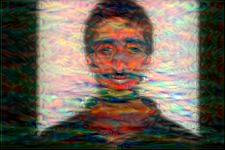

Starting iteration 10 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 5765689300.0  Improvement : 2.416 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_10.png
Iteration 10 completed in 2s


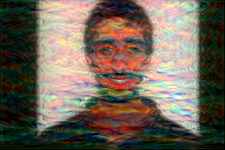

Starting iteration 11 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 5637018600.0  Improvement : 2.232 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_11.png
Iteration 11 completed in 2s
Starting iteration 12 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 5551037000.0  Improvement : 1.525 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_12.png
Iteration 12 completed in 2s
Starting iteration 13 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 5468105700.0  Improvement : 1.494 %
Rescaling Image to (150, 225)
Image saved as res_at_iteration_13.png
Iteration 13 completed in 2s
Starting iteration 14 of 500
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7f0ac9bcda90>>
Current loss value: 5392880000.0  Improvement 

In [0]:
def eval_loss_and_grads(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_width, img_height))
    else:
        x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

# By default, init_image = "content". If it was gray, it would be the same.
x = imgContent

# If init_image = "noise":
#x = np.random.uniform(0, 255, (1, img_width, img_height, 3)) - 128.
#if K.image_dim_ordering() == "th":
#  x = x.transpose((0, 3, 1, 2))

# Default color = false
color_mask = None

# Default value num_iter 10
num_iter = 500
prev_min_val = -1

# Default value min_improvement = 0.0. Defines minimum improvement required to continue the script
improvement_threshold = float(0.0)

for i in range(num_iter):
    print("Starting iteration %d of %d" % ((i + 1), num_iter))
    start_time = time.time()
    

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print("Evaluator loss",evaluator.loss)
    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print('Current loss value:', min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    
    #----------------------
    # Deprocess image
    # save current generated image
    x_copy = x.copy()    
    if K.image_dim_ordering() == "th":
        x_copy = x_copy.reshape((3, img_width, img_height))
        x_copy = x_copy.transpose((1, 2, 0))
    else:
        x_copy = x_copy.reshape((img_width, img_height, 3))

    x_copy[:, :, 0] += 103.939
    x_copy[:, :, 1] += 116.779
    x_copy[:, :, 2] += 123.68

    # BGR -> RGB
    x_copy = x_copy[:, :, ::-1]

    img = np.clip(x_copy, 0, 255).astype('uint8')
    #----------------------

    if preserve_color and content is not None:
        img = original_color_transform(content, img, mask=color_mask)

    if not rescale_image:
        img_ht = int(img_width * aspect_ratio)
        print("Rescaling Image to (%d, %d)" % (img_width, img_ht))
        img = imresize(img, (img_width, img_ht), interp="bilinear") #Default value

    if rescale_image:
        print("Rescaling Image to (%d, %d)" % (img_WIDTH, img_HEIGHT))
        img = imresize(img, (img_WIDTH, img_HEIGHT), interp="bilinear") #Default value

    fname = result_prefix + 'at_iteration_%d.png' % (i + 1)
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i + 1, end_time - start_time))
    if i in range(0,10) or i == num_iter-1:
      display(Image(fname, width=500))

    if improvement_threshold is not 0.0:
        if improvement < improvement_threshold and improvement is not 0.0:
            print("Improvement (%f) is less than improvement threshold (%f). Early stopping script." % (
                improvement, improvement_threshold))
            exit()